# 1. Проверяем гипотезу о стрельбе

> "Всегда" => подчиняется нормальному распределению

> Исхода всего 2 (попал или нет), => параметры распределения
> вычисляются по схеме Бернулли

---

> Ошибка 1 рода - гипотеза верна, но мы её не принимаем

> Ошибка 2 рода - гипотеза не верна, но мы её приняли

In [4]:
#import random
from math import sqrt
from math import erf
from math import ceil
from math import floor

```python
# Шанс промаха, Нулевая гипотеза (промахивается 1 раз из 10)
hypothesis0 = 0.1

# Шанс промаха, Альтернативная гипотеза
hypotesisA = 0.13

# Уровень значимости -- допустимый шанс на ошибку 1 рода
mistake_type1 = 0.05
# Мощность проверки -- 1 - допустимый шанс на ошибку 2 рода
mistake_type2 = 0.13
power = 0.87

# Число испытаний 
n_trials = 1000
# Число промахов
n_miss = random.randint(0, 1000)
# Среднее значение по реальной выборке
avg_real_result = n_miss / n_trials
```

In [5]:
# mu - мат. ожидание (сколько промахов в среднем, центр нормального распределения)
# s - стандартное отклонение (на какие значения отклоняется mu, определяет границы нормального распределения)
# x - точка для которой вычисляется (число промахов)

# Плотность распределения
def rho_norm(x, mu=0, s=1):
    return 1 / sqrt(2 * pi * s) * exp(-(x - mu)**2 / 2 / s**2 )

# Функция нормального распределения
def f_norm(x, mu=0, s=1):
    return (1 + erf((x - mu) / sqrt(2) / s))/2
    # erf - существующая функция ошибок, 
    # через неё выражаем функцию нормального распределения
    
# Вычисление p-значения для двустороннего теста
def p_value(x, mu=0, s=1):
    if x >= mu:
        return 2 * (1 - f_norm(x, mu, s))
    else:
        return 2 * f_norm(x, mu, s)

# Обратная функция нормального распределения
# Находит такое x, что f_norm(x) == p
def inv_f_norm(p, mu, s, t = 0.001):
    # сводим к стандартному нормальному распределению
    if mu != 0 or s != 1:
        return mu + s * inv_f_norm(p, 0, 1, t)
    # ищем x бинарным поиском
    low_x, hi_x = -100.0, 100.0
    low_p, hi_p = 0, 1

    while hi_x - low_x > t:
        mid_x = (low_x + hi_x) / 2
        mid_p = f_norm(mid_x)
        
        if mid_p < p:
            # Если меньше, поднимаем нижнюю границу
            low_x, low_p = mid_x, mid_p
        elif mid_p > p:
            # Если больше, опускаем верхнюю
            hi_x, hi_p = mid_x, mid_p
        else:
            break
    return mid_x
            

In [6]:
# Определяем количество промахов для подтверждения нулевой гипотезы (критические значения)
# Чем больше уровень значимости тем больше области по краям - то есть границы уже
# (сверху меньше, а снизу больше)
def MissAmountToProofHypothesis1(mistake_type1, mu, s) -> (int, int):
    s_low = inv_f_norm(mistake_type1 / 2, mu, s) # mu - квантиль*s
    s_high = mu + (mu - s_low)                   # mu + квантиль*s
    return (s_low, s_high)
# (Ограничивает график нормального распределения на концах - по (уровень значимости / 2) с каждой )

In [74]:
# Проверка гипотезы.
def IsHypothesisRight(
    n_trials : int,               # Всего выстрелов
    n_miss : int,                 # Число промахов
    hypothesis0 : float,          # Гипотеза стрелка о шансе про
    hypothesisA : float,          # Гипотеза тренера о шансе промаха
    mistake_type1 : float,        # Допустимая вероятность ошибки I рода (уровень значимости)
    power : float                 # Мощность проверки 
) -> bool:
    # Ошибка первого рода
    ## Аппроксимация нормальным распределением
    mu1 = n_trials * hypothesis0
    s1 = sqrt( n_trials * hypothesis0 * (1 - hypothesis0) )
    ## Критические области
    s_low, s_high = MissAmountToProofHypothesis1(mistake_type1, mu1, s1)
    s_low, s_high = ceil(s_low), floor(s_high)
    print(50*'=')
    print(f"Предельное число промахов: от {s_low} до {s_high} включительно.")
    print(f"Совершено {n_miss} промахов.")
    print(50*'=')
    if not ( n_miss >= s_low and n_miss <= s_high ):
        print(">> Нулевая гипотеза не подтверждена.")
        return False
    # Ошибка второго рода
    mu2 = n_trials * hypothesisA
    s2 = sqrt( n_trials * hypothesisA * (1 - hypothesisA) )
    ## Рассчитываем мощность проверки 
    mistake_type2 = ( f_norm(s_high, mu2, s2) - f_norm(s_low, mu2, s2) )
    cur_power = 1 - mistake_type2
    print(f"Мощность проверки: {cur_power*100:.2f}%")
    print(50*'=')
    print(f">> Нулевая гипотеза (вероятность промаха {(hypothesis0*100):.2f}%) подтверждена по уровню значимости {(mistake_type1*100):.2f}%")
    if cur_power <= 0.8:
        print(f"""Мощность проверки {(power*100):.2f}% <= 80% -- не считается значимой.
Альтернативная гипотеза требует пересмотра.""")
        return False
    if cur_power < power:
        print(f"Мощность проверки не соответствует заданной ({cur_power*100:.2f}% < {power*100:.2f}%). Гипотеза не подтверждена.")
        return False
        
    # Выводим результат
    print(f"   с мощностью проверки {(power*100):.2f}%, если тренера устраивает вероятность промаха {(hypothesisA*100):.2f}%.")
    print(50*'=')
    return True    

## Основная часть

In [9]:
#
n_trials = int(input("Всего выстрелов: "))
#
try:
    n_miss = int(input("Число промахов: "))
except Exception:
    n_miss = random.randint(0, n_trials)
    print(f"> Сл|учайно выбрано {n_miss} промахов")
#
hypothesis0 = float(input("Гипотеза стрелка о шансе промаха (%): ")) / 100
hypothesisA = float(input("Гипотеза тренера о шансе промаха (%): ")) / 100
#

mistake_type1 = float(input("Уровень значимости (допустимая вероятность ошибки I рода) (%): ")) / 100
power = float(input("Мощность проверки (%): ")) / 100

Всего выстрелов:  1000
Число промахов:  90
Гипотеза стрелка о шансе промаха (%):  9.5
Гипотеза тренера о шансе промаха (%):  13
Уровень значимости (допустимая вероятность ошибки I рода) (%):  5
Мощность проверки (%):  80


In [70]:
#
n_trials = 1000
#
n_miss = 90
#
hypothesis0 = 9.5 / 100
hypothesisA = 13 / 100
#
mistake_type1 = 5 / 100
power = 80 / 100

In [75]:
#print(50*'=')
isRight = IsHypothesisRight(n_trials, n_miss, hypothesis0, hypothesisA, mistake_type1, power)
if isRight:
    print(
r""" _____________
< It's right! >
 -------------
   \
    \
        .--.
       |o_o |
       |:_/ |
      //   \ \
     (|     | )
    /'\_   _/`\
    \___)=(___/

""")
else:
    print(
r""" ___________________
< This is boolshit! >
 -------------------
   \
    \
        .--.
       |o_o |
       |:_/ |
      //   \ \
     (|     | )
    /'\_   _/`\
    \___)=(___/

""")

Предельное число промахов: от 77 до 113 включительно.
Совершено 90 промахов.
Мощность проверки: 94.50%
>> Нулевая гипотеза (вероятность промаха 9.50%) подтверждена по уровню значимости 5.00%
   с мощностью проверки 80.00%, если тренера устраивает вероятность промаха 13.00%.
 _____________
< It's right! >
 -------------
   \
    \
        .--.
       |o_o |
       |:_/ |
      //   \ \
     (|     | )
    /'\_   _/`\
    \___)=(___/




# Проверить что последовательность аппроксимируется 
> **Центральная предельная теорема** говорит, что если какая-то функция
> описывает процесс, отклонения распределены нормально

> **Статистическая гипотеза** здесь - как раз эта функция

In [17]:
data = [1.7, -5.4, -4.0, -5.9, -1.6, 0.0, 0.6, 2.1, 0.1, -4.9, -3.5, 5.9, 8.5, 9.9, 13.3, 11.1, 14.4, 16.2]
#data = [11,13,20,30,50,60]
key_value = 0.05

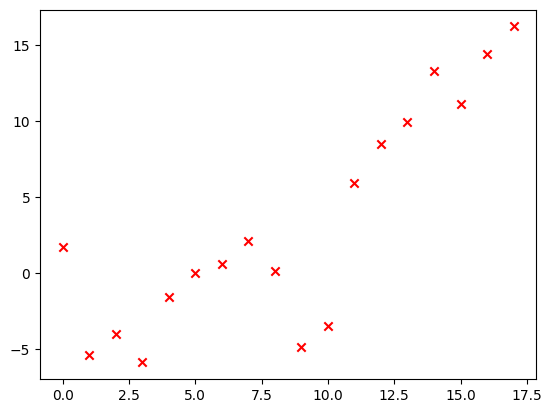

In [18]:
from matplotlib import pyplot as plt
from math import exp
xs = list(range(0, len(data)))
# Наша последовательность
plt.scatter(xs, data, color='red', marker='x')
plt.show()

## 1) Экспоненциальной функцией по уровню значимости 5%
> Перед началом выполнить блок с функцией p_value и импорты для него

In [19]:
from matplotlib import pyplot as plt
from math import exp
from math import log
from math import sqrt

### Аппроксимация (линейная регрессия)

In [20]:
# data - последовательность
# xs - соответствующие иксы
# Вернёт A и b (y = A * e**(b * x))
def approx_exp(data, xs=None) -> (float, float):
    n = len(data)
    if not xs: xs = range(n)
    ln_data = list(map(log, data))
    sum_xs, sum_ln_data = sum(xs), sum(ln_data)
    sum_xs_pow2 = sum( [ x**2 for x in xs ] )
    sum_xs_ln_data = sum( [ x*l for x, l in zip(xs, ln_data) ] )
    a = (sum_xs_ln_data*sum_xs - sum_ln_data*sum_xs_pow2) / (sum_xs**2 - sum_xs_pow2 * n)
    b = (sum_ln_data*sum_xs - sum_xs_ln_data*n) / (sum_xs**2 - sum_xs_pow2 * n)
    return a, b

### Вычисляем значения и строим график

A = 1.1583914560044861
b = 0.17763646078079456


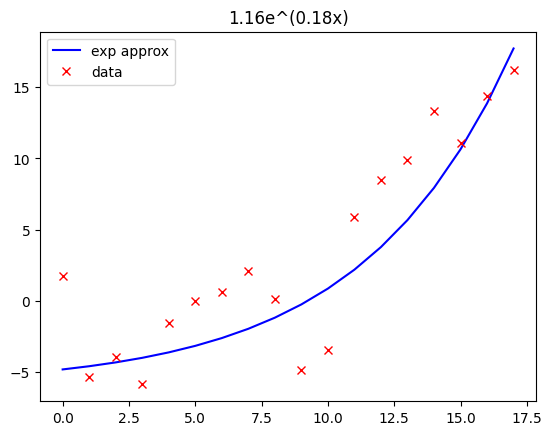

In [21]:
# Смещаем вверх чтобы избежать отрицательных чисел
shift = min(data)
shift = 0 if shift >= 0 else abs(shift)+0.1 # Если числа не отрицательные, сдвиг не нужен
udata = [d + shift for d in data]
#print(shift)
#print(udata)
# Иксы
xs = list(range(len(udata)))
# Получаем коэффициенты аппроксимации
a,b = approx_exp(udata, xs)
A = exp(a)
print(f"A = {A}\nb = {b}")
# Список координат y для всех x, соответствующих data
uapprox_exp_data = list(map(lambda x: A*exp(b * x), xs))
approx_exp_data = [d - shift for d in uapprox_exp_data]

# Отображаем
plt.plot(xs, approx_exp_data, color='blue', marker='', linestyle="-", label="exp approx")
plt.plot(xs, data, color='red', marker='x', linestyle="", label="data")
plt.title(f"{A:.2f}e^({b:.2f}x)")
plt.legend()
plt.show()

### Проверяем статистическую гипотезу

> ### !!! p-значение !!!
> -- это реальная вероятность ошибки I рода (насколько часто мы отвергаем верную гипотезу). Ключевое значение - насколько часто мы можем себе позволить ошибаться. Если p-value **больше** ключевого значения -- гипотеза верна (исключена ошибка первого рода). Мы как бы говорим "мы можем позволить себе ошибиться только в A% случаев. В ином случае мы не будем рисковать и опровергать гипотезу".

> Заострил внимание потому что изначально понял p-значение с точностью до наоборот

In [22]:
def StatisticTest(data, approx_exp_data, xs) -> (float, float, float):
    # Вычисляем отклонение от среднего (разница между фактическим и предсказанным)
    residuals = [ d_real - d_appr for d_real, d_appr in zip(data, approx_exp_data)]
    #print(residuals)
    # Максимальное отклонение от среднего (получаем индекс)
    max_res_x = max(range(len(residuals)), key=lambda x: abs(residuals[x]))
    print(f"Максимальное отклонение от среднего: {residuals[max_res_x]:.3f}")
    
    # Стандартное отклонение
    n = len(residuals)
    mu = sum(residuals) / n
    s = sqrt( sum( (d - mu)**2 for d in residuals ) / (n-1))
    print(f"Математическое ожидание: {mu:.2f}")
    print(f"Стандартное отклонение: {s:.2f}")
    
    # Считаем p-value для наибольшего отклонения
    max_p_value = p_value(residuals[max_res_x], mu, s)

    print(f"p-значение для максимального отклонения: {max_p_value:.2f}")
    return max_p_value, mu, s

p_val_exp, mu_exp, s_exp = StatisticTest(data, approx_exp_data, xs)
print(f"Ключевое значение: {key_value}")
print(50*'=')
if p_val_exp >= key_value:
    print(f">> Гипотеза об аппроксимации подтверждена с вероятностью {(1-key_value)*100:.2f}%")
else:
    print(f">> Гипотеза об аппроксимации не подтверждена с вероятностью {(1-key_value)*100:.2f}%")

Максимальное отклонение от среднего: 6.542
Математическое ожидание: 1.48
Стандартное отклонение: 3.23
p-значение для максимального отклонения: 0.12
Ключевое значение: 0.05
>> Гипотеза об аппроксимации подтверждена с вероятностью 95.00%


## 2) Полиномиальной функцией 4 порядка по уровню значимости 5%

### Решение матричного уравнения методом Гаусса-Джордана

In [23]:
def printM(M : list[list]):
    for row in M:
        print( row )

In [24]:
# Ax=b
def Gauss(myA : list[list], b : list) -> list: 
    print(50*'=')
    print("### Решение")
    print(50*'=')
    
    A = [ row[:] for row in myA ]
    rows = len(A)
    
    # Объединяем в одну матрицу для удобства
    for r in range(rows): A[r].append(b[r])
    cols = len(A[0])
    
    print("Матрица:")
    printM(A)
    print(50*'=')
    
    # Прямой ход
    for row in range(rows):
        col = row
        maxRow = row
        for r in range(row+1, rows):
            if abs(A[r][col]) > abs(A[maxRow][col]): maxRow = r
        ## Меняем текущую строку и строку с ведущим элементом
        A[row], A[maxRow] = A[maxRow], A[row]
        ## Нормализуем строку по ведущему элементу
        pivot = A[row][col]
        if not pivot: 
            print("Матрица не имеет решений, либо решений бесконечно много!")
            return []
        for c in range(col, cols):
            A[row][c] /= pivot
        ## Вычитаем текущую строку из нижних
        for r in range(row+1, rows):
            coeff = A[r][col]
            for c in range(cols):
                # Цель - обнулить элементы снизу (чтобы получился "треугольник")
                # Так как у ведущего коэффициент 1, домножаем на число под ним из нужной строки
                # Таким образом это число обнулится после вычитания
                A[r][c] -= coeff * A[row][c]
    print("После прямого хода:")
    printM(A)
    print(50*'=')
    # Обратный ход
    x = [ 0 for _ in range(cols-1) ] # массив решений (там где не вычислено, будет 0)
    ## Идём с конца
    for i in range(rows-1, -1, -1):
        res = A[i][cols-1] # колонка b
        for k in range(i+1, cols-1):
            res -= x[k] * A[i][k] # Вычитаем из b уже вычисленные члены
            # (так как идём с конца, каждый раз будет оставаться один невычисленный с коэффициентом 1)
        x[i] = res # А вот и он
    print("Решение:")
    print(x)
    return x

# Проверка решения
def GaussTest(A : list[list], x : list, b : list, eps=1e-4) -> bool:
    print(50*'=')
    print("### Проверка")
    print(50*'=')
    allOK = True
    for row, equ in enumerate(A):
        print(equ)
        result = sum( c * x[i] for i, c in enumerate(equ))
        isOK = ( abs(result - b[row]) < eps)
        print(f"{result} == {b[row]}?")
        print(isOK)
        allOK = allOK and isOK
    print(50*'=')
    print(">> Решение верное" if allOK else ">> Решение неверное")
    return allOK

In [25]:
# Тест
A1 = [
    [3, 2, -1],
    [2, -1, 5],
    [1, 7, -1]
]
b1 = [4, 23, 5]
x1 = Gauss(A1, b1)
GaussTest(A1, x1, b1)

### Решение
Матрица:
[3, 2, -1, 4]
[2, -1, 5, 23]
[1, 7, -1, 5]
После прямого хода:
[1.0, 0.6666666666666666, -0.3333333333333333, 1.3333333333333333]
[0.0, 1.0, -0.10526315789473686, 0.5789473684210527]
[0.0, 0.0, 1.0, 3.9999999999999996]
Решение:
[1.9999999999999996, 1.0, 3.9999999999999996]
### Проверка
[3, 2, -1]
3.9999999999999987 == 4?
True
[2, -1, 5]
22.999999999999996 == 23?
True
[1, 7, -1]
5.0 == 5?
True
>> Решение верное


True

### Аппроксимация

### Вычисляем значения и строим график

In [26]:
# data - последовательность
# xs - соответствующие иксы
# deg - степень полиномизации
# Вернёт веектор коэффициентов a (результат решения Ma=b)
def approx_poly(data, xs=None, deg=4) -> list:
    if not xs: xs = range(n)
    M = [ [] for _ in range(deg+1) ]
    b = []
    for i in range(deg+1):
        for j in range(deg+1):
            M[i].append( sum( list( map(lambda x: x**(i+j), xs) ) ) )
        b.append( sum(d*x**i for d, x in zip(data, xs)) )
    a = Gauss(M, b)
    GaussTest(M, a, b, 1e-2)
    return a

In [27]:
poly_degree = 4
a = approx_poly(data, xs, poly_degree)

### Решение
Матрица:
[18, 153, 1785, 23409, 327369, 58.5]
[153, 1785, 23409, 327369, 4767633, 1056.6]
[1785, 23409, 327369, 4767633, 71397705, 16367.400000000001]
[23409, 327369, 4767633, 71397705, 1091194929, 250351.8]
[327369, 4767633, 71397705, 1091194929, 16937207049, 3853144.2]
После прямого хода:
[1.0, 14.563483408630628, 218.09549774108118, 3333.226203458483, 51737.357688113414, 11.77003381505274]
[0.0, 1.0, 24.931716883580002, 489.37047602068145, 8852.123373150302, 1.8581116179382244]
[0.0, 0.0, 1.0, 32.67961165048476, 759.2071197410861, 0.06419347674344958]
[0.0, 0.0, 0.0, 1.0, 36.5503955968375, -0.005678901111619218]
[0.0, 0.0, 0.0, 0.0, 1.0, -0.0005148231541415438]
Решение:
[-1.455768208399249, -0.6548289916718373, 0.025703239828822166, 0.013138088834665856, -0.0005148231541415438]
### Проверка
[18, 153, 1785, 23409, 327369]
58.499999999999964 == 58.5?
True
[153, 1785, 23409, 327369, 4767633]
1056.5999999999995 == 1056.6?
True
[1785, 23409, 327369, 4767633, 71397705]
16367.3

[-1.455768208399249, -2.0722706945617397, -2.5657456922165727, -2.875898301904848, -2.954789379867064, -2.766835538043114, -2.28880914407229, -1.509838321293282, -0.4314069487441734, 0.9326453388375513, 2.5561231510150133, 4.400475341651935, 6.414795008912645, 8.535819495262064, 10.687930387465734, 12.783153516589788, 14.721158958000963, 16.389261031366598]


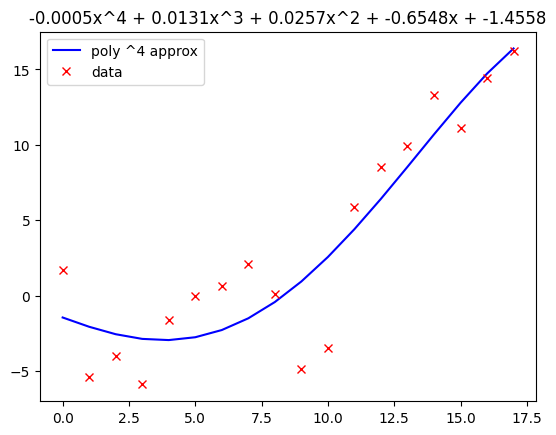

In [28]:
# Считаем точки для графика
approx_poly_data = [ sum([a[i]*(x**(i)) for i, _ in enumerate(a) ]) for x in xs]
print(approx_poly_data)
# Отображаем
plt.plot(xs, approx_poly_data, color='blue', marker='', linestyle="-", label=f"poly ^{poly_degree} approx")
plt.plot(xs, data, color='red', marker='x', linestyle="", label="data")
plt.title(' + '.join([ f"{a[i]:.4f}x^{i}" for i in range(len(a)-1, -1, -1) ]).replace("x^1", 'x').replace("x^0", ''))
plt.legend()
plt.show()

### Проверяем статистическую гипотезу

In [29]:
p_val_poly, mu_poly, s_poly = StatisticTest(data, approx_poly_data, xs)
print(f"Ключевое значение: {key_value}")
print(50*'=')
if p_val_poly >= key_value:
    print(f">> Гипотеза об аппроксимации подтверждена с вероятностью {(1-key_value)*100:.2f}%")
else:
    print(f">> Гипотеза об аппроксимации не подтверждена с вероятностью {(1-key_value)*100:.2f}%")

Максимальное отклонение от среднего: -6.056
Математическое ожидание: 0.00
Стандартное отклонение: 2.99
p-значение для максимального отклонения: 0.04
Ключевое значение: 0.05
>> Гипотеза об аппроксимации не подтверждена с вероятностью 95.00%


# Рассчитываем мощность проверки для предыдущих пунктов
> Принимаем лучшую функцию за нулевую гипотезу, а худшую - за альтернативную

In [23]:
# Ищем автоматически, какая аппроксимация соответствует какой гипотезе
hypothesis0 = max(p_val_exp, p_val_poly, key=lambda p_val: p_val - key_value )
hypothesisA = min(p_val_exp, p_val_poly, key=lambda p_val: p_val - key_value )

type0 = ('exp' if hypothesis0 == p_val_exp else 'poly')
typeA = ('poly' if hypothesisA == p_val_poly else 'exp')

print(f"Нулевая гипотеза:        {hypothesis0:.6f} -- {type0}")
print(f"Альтернативная гипотеза: {hypothesisA:.6f} -- {typeA}")

Нулевая гипотеза:        0.116782 -- exp
Альтернативная гипотеза: 0.043061 -- poly


In [24]:
if type0 == 'exp':
    mu1 = mu_exp
    s1 = s_exp
    mu2 = mu_poly
    s2 = s_poly
else:
    mu1 = mu_poly
    s1 = s_poly
    mu2 = mu_exp
    s2 = s_exp
    
print(50*'=')
print("Нулевая гипотеза:")
print(f"mu = {mu1}")
print(f"s = {s1}")
print(50*'=')
print("Альтернативная гипотеза:")
print(f"mu = {mu2}")
print(f"s = {s2}")
print(50*'=')

s_low, s_high = MissAmountToProofHypothesis1(key_value, mu1, s1)
print(f"Допустимый интервал: от {s_low} до {s_high}")
power = ( f_norm(s_high, mu2, s2) - f_norm(s_low, mu2, s2) )
print(50*'=')
print(f"Мощность проверки: {power*100:.2f}%")

Нулевая гипотеза:
mu = 1.479955419280131
s = 3.2272242826618625
Альтернативная гипотеза:
mu = 2.3129646346357427e-15
s = 2.993455678694586
Допустимый интервал: от -4.845376598357751 до 7.805287436918013
Мощность проверки: 94.27%


# Пробуем уменьшить выборку и провести полиномиальную аппроксимацию 7 порядка
> Мы должны увидеть, что p-значение (вероятность ошибки I рода) с уменьшенной выборкой больше.


## С неполной выборкой

In [51]:
short_data = data[:-4]
short_xs = list(range(len(short_data)))
poly_degree = 7
a1 = approx_poly(short_data, short_xs, poly_degree)

### Решение
Матрица:
[14, 91, 819, 8281, 89271, 1002001, 11562759, 136147921, 3.4999999999999996]
[91, 819, 8281, 89271, 1002001, 11562759, 136147921, 1627802631, 198.10000000000002]
[819, 8281, 89271, 1002001, 11562759, 136147921, 1627802631, 19696532401, 2894.9]
[8281, 89271, 1002001, 11562759, 136147921, 1627802631, 19696532401, 240627622599, 37821.1]
[89271, 1002001, 11562759, 136147921, 1627802631, 19696532401, 240627622599, 2962844754961, 483515.30000000005]
[1002001, 11562759, 136147921, 1627802631, 19696532401, 240627622599, 2962844754961, 36720042483591, 6141765.100000001]
[11562759, 136147921, 1627802631, 19696532401, 240627622599, 2962844754961, 36720042483591, 457593884876401, 77804576.9]
[136147921, 1627802631, 19696532401, 240627622599, 2962844754961, 36720042483591, 457593884876401, 5729082486784839, 984385929.1]
После прямого хода:
[1.0, 11.956132852002932, 144.67009306003285, 1767.3984356984784, 21761.95371327778, 269706.9644096218, 3361005.305959839, 42079838.19881347

[1.4932242222735113, -4.392112705900592, -5.765053943230846, -4.598545261787674, -2.162400910922662, 0.2754890871526836, 1.5162487847751116, 0.9030415320372001, -1.1623311913927523, -3.021619103026694, -2.2434623700759175, 2.8497574450829006, 10.249192979298414, 9.558571435717909]


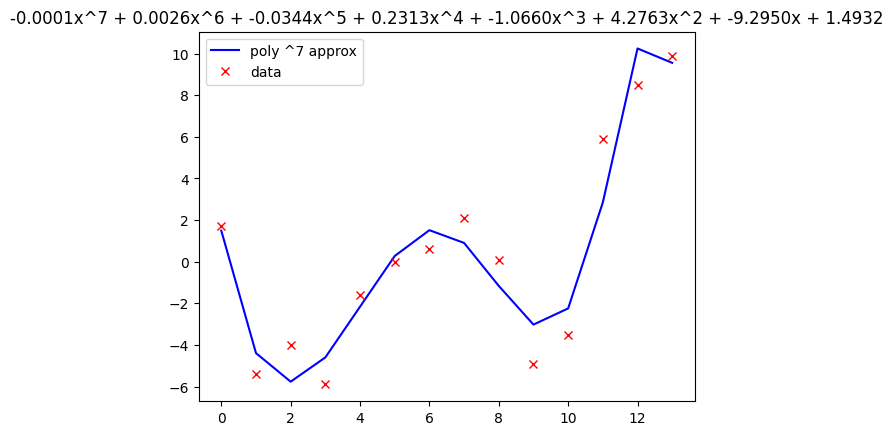

In [52]:
approx_poly_data1 = [ sum([a1[i]*(x**(i)) for i, _ in enumerate(a1) ]) for x in short_xs]
print(approx_poly_data1)
# Отображаем
plt.plot(short_xs, approx_poly_data1, color='blue', marker='', linestyle="-", label=f"poly ^{poly_degree} approx")
plt.plot(short_xs, short_data, color='red', marker='x', linestyle="", label="data")
plt.title(' + '.join([ f"{a1[i]:.4f}x^{i}" for i in range(len(a1)-1, -1, -1) ]).replace("x^1", 'x').replace("x^0", ''))
plt.legend()
plt.show()

In [43]:
p_val_poly1, mu_poly, s_poly = StatisticTest(short_data, approx_poly_data1, short_xs)
#p_val_poly1 = p_valuef(short_data, approx_poly_data1, short_xs)
print(f"p-value: {p_val_poly1}")

Максимальное отклонение от среднего: 3.050
Математическое ожидание: -0.00
Стандартное отклонение: 1.46
p-значение для максимального отклонения: 0.04
p-value: 0.036696922477596594


## С полной выборкой

In [46]:
#a2 = approx_poly(data, xs, poly_degree)

[1.4932242222735113, -4.392112705900592, -5.765053943230846, -4.598545261787674, -2.162400910922662, 0.2754890871526836, 1.5162487847751116, 0.9030415320372001, -1.1623311913927523, -3.021619103026694, -2.2434623700759175, 2.8497574450829006, 10.249192979298414, 9.558571435717909, -24.837362043666076, -143.09735976713034, -432.1035074113074, -1030.8587422352175]


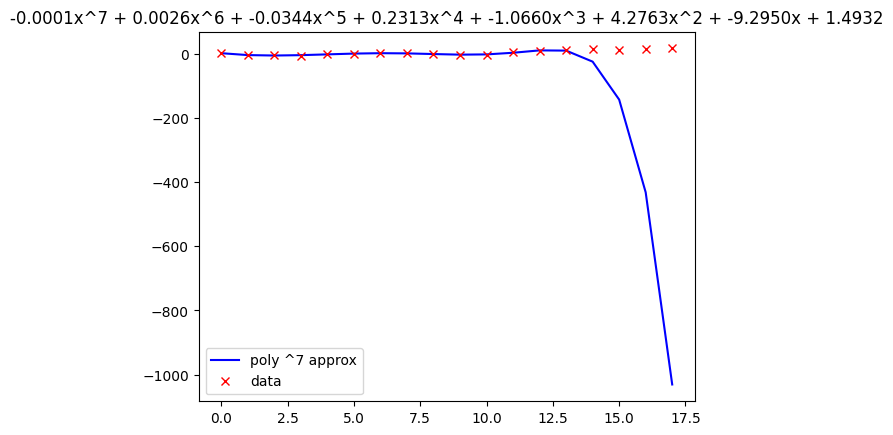

In [59]:
approx_poly_data2 = [ sum([a1[i]*(x**(i)) for i, _ in enumerate(a1) ]) for x in xs]
print(approx_poly_data2)
# Отображаем
plt.plot(xs, approx_poly_data2, color='blue', marker='', linestyle="-", label=f"poly ^{poly_degree} approx")
plt.plot(xs, data, color='red', marker='x', linestyle="", label="data")
plt.title(' + '.join([ f"{a1[i]:.4f}x^{i}" for i in range(len(a1)-1, -1, -1) ]).replace("x^1", 'x').replace("x^0", ''))
plt.legend()
plt.show()

In [55]:
p_val_poly2, mu_poly, s_poly = StatisticTest(data, approx_poly_data2, xs)
#p_val_poly2 = p_valuef(data, approx_poly_data2, xs)
print(f"p-value: {p_val_poly2}")

Максимальное отклонение от среднего: 1047.059
Математическое ожидание: 93.66
Стандартное отклонение: 261.56
p-значение для максимального отклонения: 0.00
p-value: 0.0002673814035969446


In [56]:
# Резюме
print(f"p-value для графика с неполной выборкой: {p_val_poly1:.7f}")
print(f"p-value для графика с полной выборкой: {p_val_poly2:.7f}")

p-value для графика с неполной выборкой: 0.0366969
p-value для графика с полной выборкой: 0.0002674


## p-значение уменьшилось

#### Почему так могло произойти?
> То что во втором случае p-value значительно меньше говорит о том, что гипотеза об аппроксимации полиномом 7 степени скорее всего не верна, а выяснилось это только на полном обьёме данных.

> Это особенность полинома - он сильно "выгибается" от значений в выборке.  Это показывает нецелесообразность полиномов высокой степени как статистических гипотез, и именно поэтому обычно для таких целей не используют полиномы более чем 4 степени
